In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install xgboost

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [ ]:
parent_dir = '/content/drive/My Drive'
if os.path.exists(parent_dir):
    print("Contents of My Drive:")
    print(os.listdir(parent_dir))

Contents of My Drive:
['Colab Notebooks', 'PlantDocDataset', 'Crop', 'LSTM', 'Tomato-2', 'DAtaset']


In [ ]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/content/drive/My Drive/Tomato-2'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Streaming output truncated to the last 5000 lines.
/content/drive/My Drive/Tomato-2/TRAIN/tr/Tomato___Leaf_Mold/707469c1-31f4-4c33-ae84-432e70e0c399___Crnl_L.Mold 9034.JPG
/content/drive/My Drive/Tomato-2/TRAIN/tr/Tomato___Leaf_Mold/156f079b-411f-41db-8023-fa934de343f9___Crnl_L.Mold 7039.JPG
/content/drive/My Drive/Tomato-2/TRAIN/tr/Tomato___Leaf_Mold/f0c85df0-2aaf-48c6-a90b-05b78a59bcc5___Crnl_L.Mold 6624.JPG
/content/drive/My Drive/Tomato-2/TRAIN/tr/Tomato___Leaf_Mold/dbbb1200-16e8-4842-acbf-57ccd1afc2dc___Crnl_L.Mold 7035.JPG
/content/drive/My Drive/Tomato-2/TRAIN/tr/Tomato___Leaf_Mold/a6308326-2fcb-4690-aec2-2e0b4f21efd6___Crnl_L.Mold 8817.JPG
/content/drive/My Drive/Tomato-2/TRAIN/tr/Tomato___Leaf_Mold/35343df4-2017-47f9-a5ef-d08bd52dfd7c___Crnl_L.Mold 8827.JPG
/content/drive/My Drive/Tomato-2/TRAIN/tr/Tomato___Leaf_Mold/af1c1bf4-43b5-47ff-aade-ebd32635f77a___Crnl_L.Mold 7045.JPG
/content/drive/My Drive/Tomato-2/TRAIN/tr/Tomato___Leaf_Mold/Tomato___Leaf_Mold_original_75b10923-dfb7

In [ ]:
!pip install tensorflow==2.12
import os
import pandas as pd
import numpy as np
import tensorflow as tf


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.layers import Dense, InputLayer, Dropout, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping as ES
from IPython.display import clear_output as cls


import plotly.express as px
import matplotlib.pyplot as plt

In [ ]:
batchSize = 32
imageShape = (224, 224)
epochs = 10
channels = 3

In [ ]:
data_dir = '/content/drive/My Drive/Tomato-2'

In [ ]:
train_dir = "/content/drive/My Drive/Tomato-2/TRAIN/tr"
val_dir = "/content/drive/My Drive/Tomato-2/VAL/test"

In [ ]:
class_names = sorted(os.listdir(train_dir))
class_names

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [ ]:
class_dis = [len(os.listdir(os.path.join(train_dir, name))) for name in class_names]
class_dis

[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]

In [ ]:
fig = px.pie(names=class_names, values=class_dis, hole=0.3)
fig.update_layout({"title":{"text":"Distibution of classes", "x":0.50}})
fig.show()

In [ ]:
train_gen = ImageDataGenerator(rescale=(1./255.), validation_split=0.2)
val_gen = ImageDataGenerator(rescale=(1./255.))

In [ ]:
train_ds = train_gen.flow_from_directory(train_dir,target_size=imageShape,batch_size=batchSize, subset='training', class_mode='categorical')
val_ds = train_gen.flow_from_directory(train_dir,target_size=imageShape,batch_size=batchSize, subset='validation', class_mode='categorical')

Found 8000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.


In [ ]:
test_ds = val_gen.flow_from_directory(val_dir,target_size=imageShape,batch_size=batchSize, class_mode='categorical')


Found 1000 images belonging to 10 classes.


In [ ]:
def plot_images(data, class_names):

    r, c = 3, 4
    imgLen = r*c

    plt.figure(figsize=(20, 15))
    i = 1

    for images, labels in iter(data):


        id = np.random.randint(len(images))

        img = tf.expand_dims(images[id], axis=0)
        lab = class_names[np.argmax(labels[id])]

        plt.subplot(r, c, i)
        plt.imshow(img[0])
        plt.title(lab)
        plt.axis('off')
        cls()

        i+=1
        if i > imgLen:
          break
    plt.show()

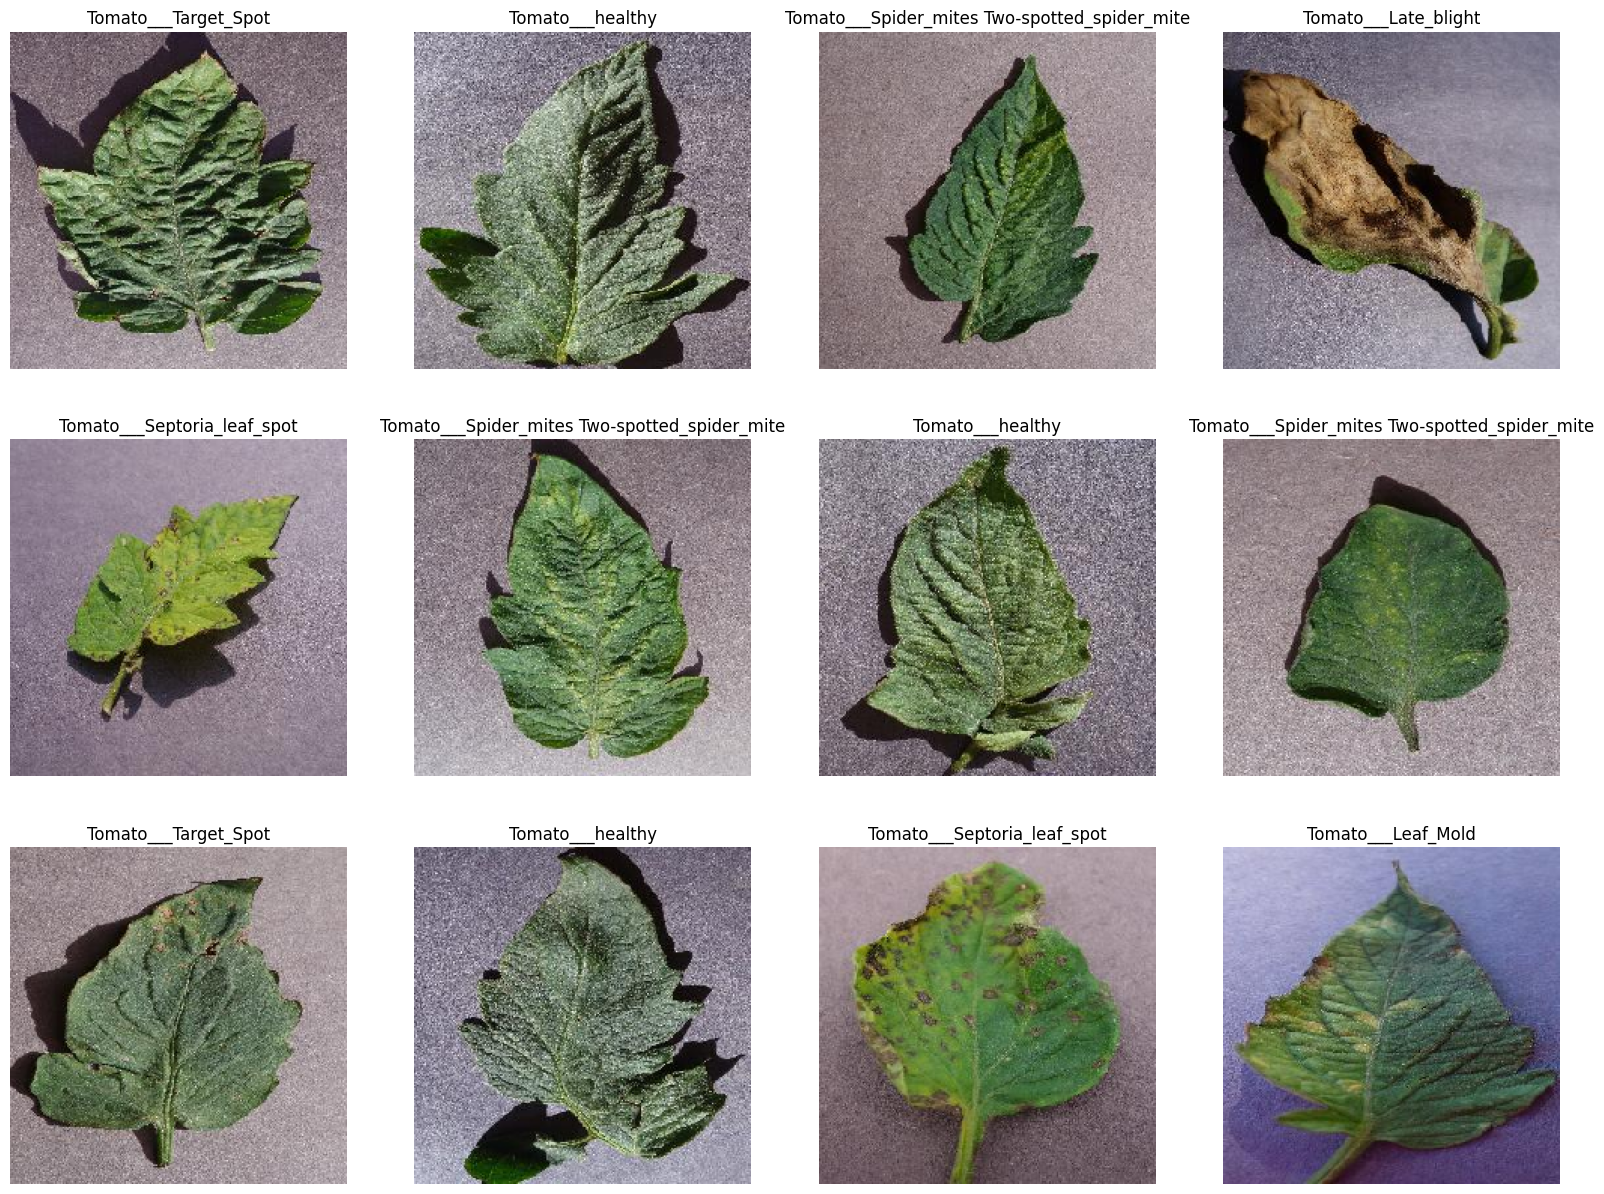

In [ ]:
plot_images(train_ds, class_names)

In [ ]:
def get_model():

    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layers in base_model.layers:
        layers.trainable = False

    base_model_output = base_model.output

    x = Flatten()(base_model_output)
    x = Dense(512, activation='relu')(x)
    x = Dense(len(class_names), activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=x)
    return model


In [ ]:
model = get_model()

model.compile(loss="categorical_crossentropy",
             optimizer="sgd",
             metrics=["accuracy"])

model.summary()

87910968/87910968 [==============================] - 4s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                  

In [ ]:
history = model.fit(train_ds,
                   validation_data=val_ds,
                   epochs=5,
                   steps_per_epoch=len(train_ds),
                   validation_steps=len(val_ds),
                   callbacks=[ES(monitor="val_loss", patience=5)])

Epoch 1/5
188/250 [=====================>........] - ETA: 19:39 - loss: 1.8278 - accuracy: 0.4993

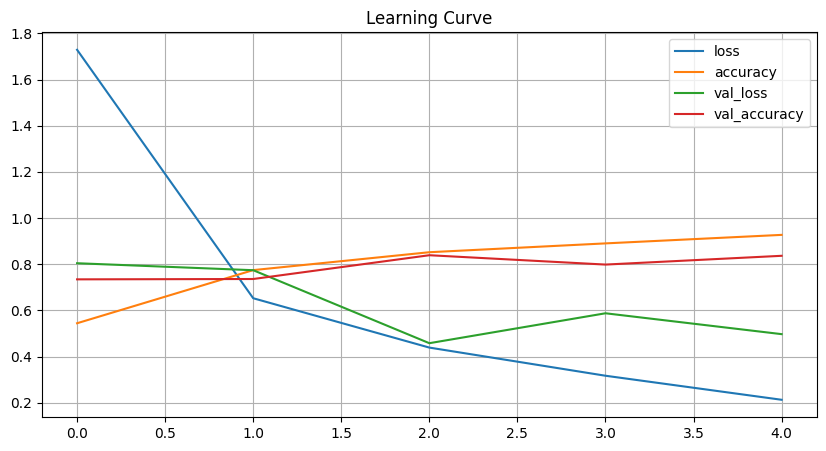

In [ ]:

learningcurve = pd.DataFrame(history.history)
learningcurve.plot(figsize=(10, 5))
plt.title("Learning Curve")
plt.grid()

In [ ]:
model.evaluate(train_ds, verbose=1)

250/250 [==============================] - 651s 3s/step - loss: 0.1538 - accuracy: 0.9526


[0.15383559465408325, 0.9526249766349792]

In [ ]:
def predictImages(data, class_names, model):
    r, c = 3, 4
    imgLen = r * c
    plt.figure(figsize=(20, 15))
    i = 1

    disease_treatments = {
        'Tomato___Bacterial_spot': "Use copper-based bactericides and avoid overhead watering.",
        'Tomato___Early_blight': "Apply fungicides like chlorothalonil and practice crop rotation.",
        'Tomato___Late_blight': "Use fungicides like mancozeb and remove infected plants immediately.",
        'Tomato___Leaf_Mold': "Ensure good air circulation and apply fungicides if needed.",
        'Tomato___Septoria_leaf_spot': "Use fungicides like copper-based sprays and remove affected leaves.",
        'Tomato___Spider_mites Two-spotted_spider_mite': "Spray neem oil or use insecticidal soap.",
        'Tomato___Target_Spot': "Apply fungicides and avoid excessive nitrogen fertilizers.",
        'Tomato___Tomato_Yellow_Leaf_Curl_Virus': "Use resistant varieties and control whiteflies with neem oil or insecticides.",
        'Tomato___Tomato_mosaic_virus': "Remove infected plants and disinfect tools to prevent spread.",
        'Tomato___healthy': "No treatment needed! Keep monitoring for any signs of disease."
    }

    for images, labels in iter(data):
        id = np.random.randint(len(images))
        img = tf.expand_dims(images[id], axis=0)
        plt.subplot(r, c, i)
        plt.imshow(img[0])

        predicted = model.predict(img)
        predicted_label = class_names[np.argmax(predicted)]
        actual = class_names[np.argmax(labels[id])]

        treatment = disease_treatments.get(predicted_label, "No information available.")
        plt.title(f"Actual: {actual}\nPredicted: {predicted_label}\nTreatment: {treatment}")
        plt.axis('off')

        i += 1
        if i > imgLen:
            break

    plt.show()


1/1 [==============================] - 0s 116ms/step


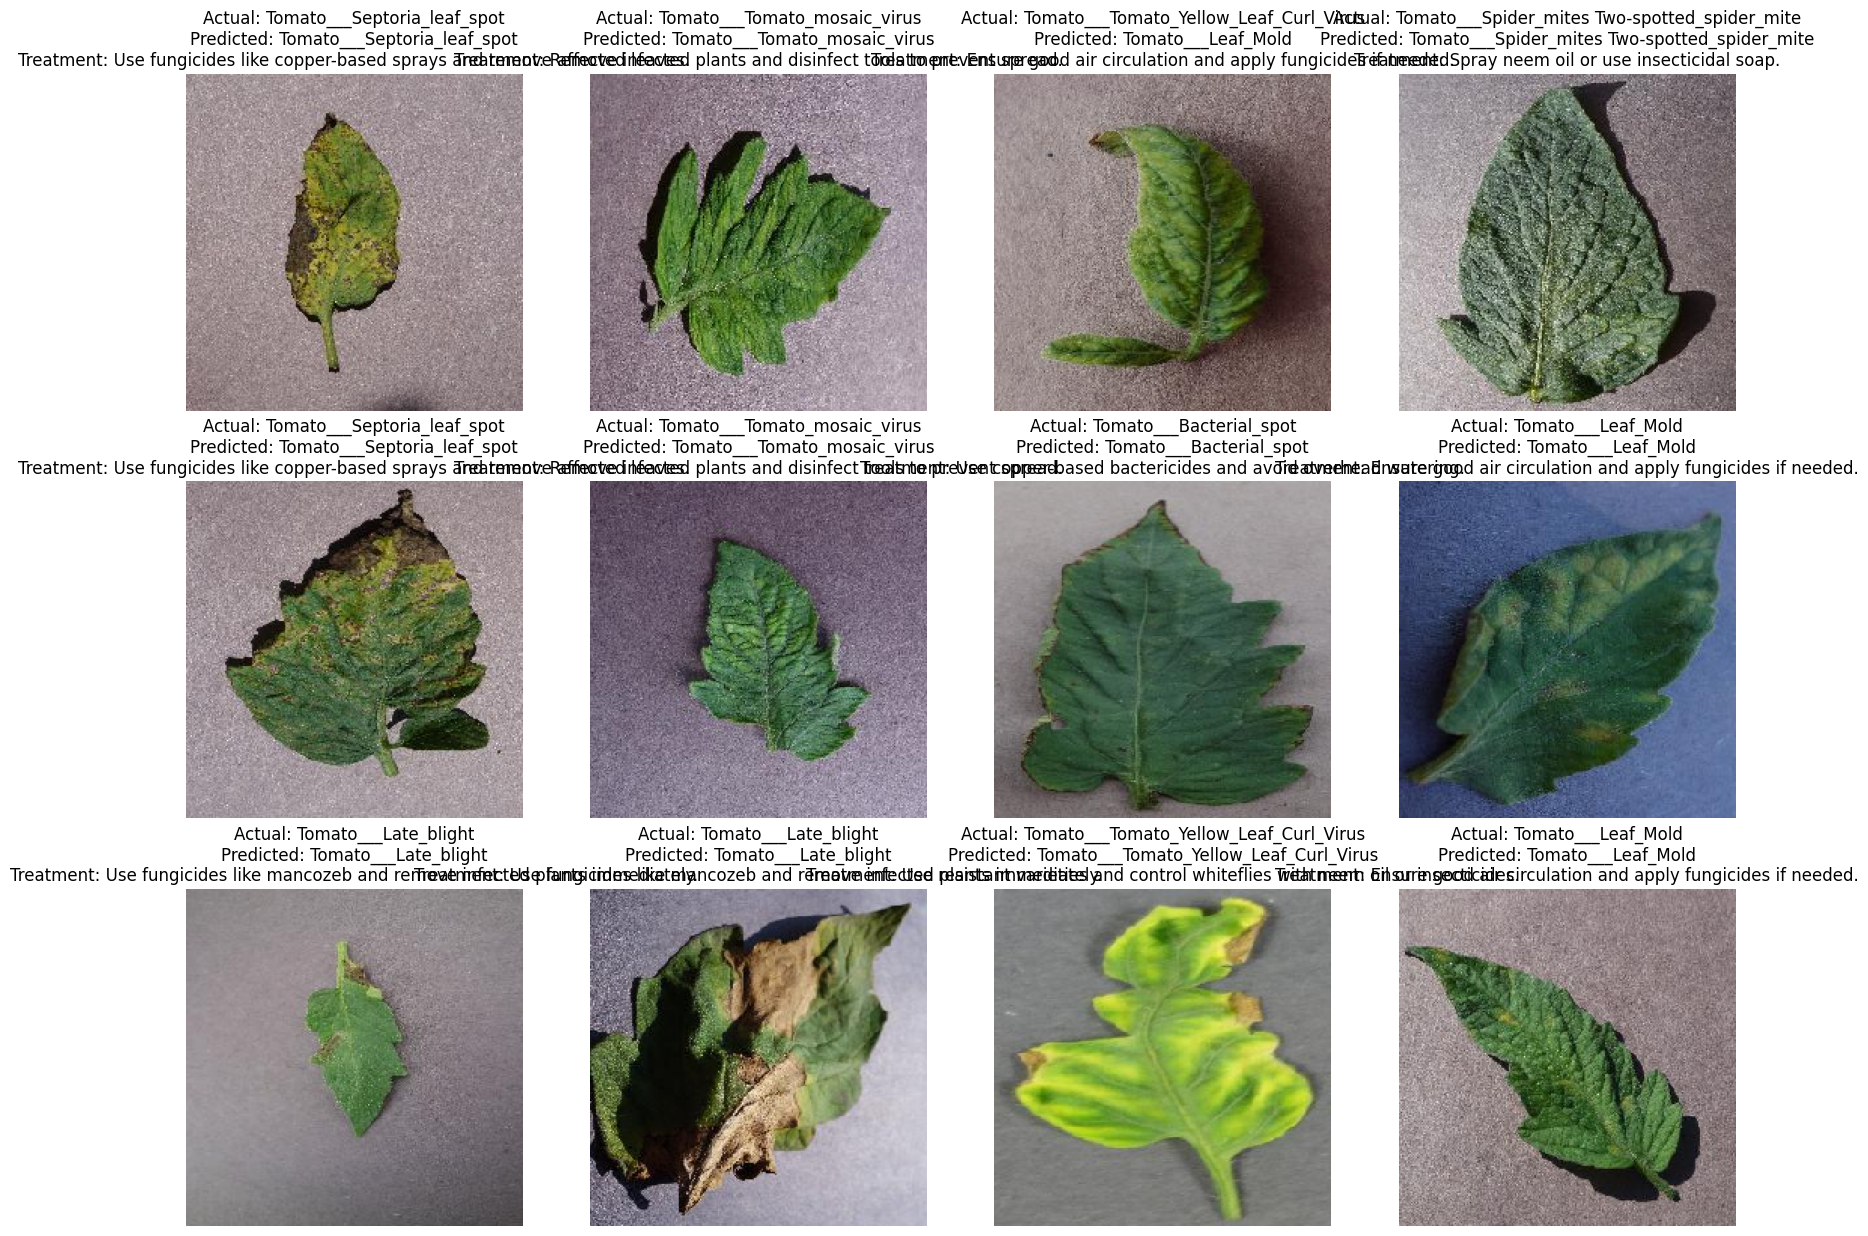

In [ ]:
predictImages(test_ds, class_names, model)